In [1]:
from mip import *
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
from math import *

# Parameter

In [54]:
N = 2
T = 10
set_N = set(range(N))
set_T = set(range(T))
d_s = [5000/(1+50*np.exp(-0.1*(t+1))) for t in set_T]
d_m = [279/(1+2.2*np.exp(-0.33*(t+1))) for t in set_T]
d_f = [258/(1+3.4*np.exp(-0.9*(t+1))) for t in set_T]
h = [[6,6,6,6,6,6,6,6,6,6,6],[7,7,7,7,7,7,7,7,7,7]]
mu = [[5,5,5,5,5,5,5,5,5,5],[5,5,5,5,5,5,5,5,5,5]]
r = 1
s = [50,50]
Pmax = [10,10]
delta = [5,5]
tau = [1, 1]
g = [[Pmax[i] - delta[i]*np.exp(-(t+1)/tau[i]) for t in set_T] for i in set_N]
alpha = 2
M = 1000000



# Demand downturn in year 5

demand에 따라 put, withdraw pattern이 어떻게 변할지

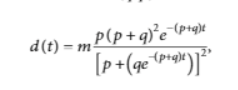

In [55]:
# p == u
# q == v
# m == a
u = 0.053
v = 0.4
a = 2050
d_my = [(a*u*((u+v)**2)*np.exp(-(u+v)*t)/(u+(v*np.exp(-(u+v)*t)))**2) for t in set_T]
d = d_my

C:\ProgramData\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\anacond

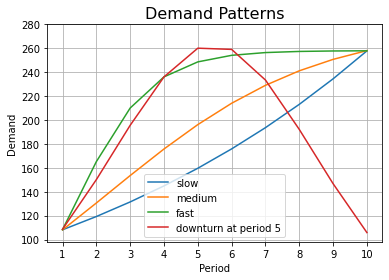

In [56]:
sns.lineplot(list(set_T),d_s,label='slow')
sns.lineplot(list(set_T),d_m,label='medium')
sns.lineplot(list(set_T),d_f,label='fast')
sns.lineplot(list(set_T),d_my,label='downturn at period 5')



plt.xlabel('Period')
plt.xticks(range(0,10), range(1,11))
plt.ylabel('Demand')
plt.yticks(range(100,300,20), range(100,300,20))
plt.title('Demand Patterns', fontsize =16)
plt.legend()
plt.grid()

plt.show()

# my_model

In [57]:
m_my = Model()

# Variables 

In [58]:
l = [[m_my.add_var(name='l({},{})'.format(i,t)) for t in set_T] for i in set_N]
p = [[m_my.add_var(name='p({},{})'.format(i,t)) for t in set_T] for i in set_N]
#w = [[[m.add_var(name='w({},{},{})'.format(i,t_p,t)) for t in T if t>=t_p]  for t_p in T] for i in N]
w = [[[m_my.add_var(name='w({},{},{})'.format(i,t_p,t)) for t in set_T ]  for t_p in set_T] for i in set_N]
z = [[[m_my.add_var(name='z({},{},{})'.format(i,t_p,t)) for t in set_T ]  for t_p in set_T] for i in set_N]
y = [[m_my.add_var(name='y({},{})'.format(i,t), var_type=BINARY) for t in set_T] for i in set_N]
y_a = [[m_my.add_var(name='y_a({},{})'.format(i,t), var_type=BINARY) for t in set_T] for i in set_N]
y_w = [[m_my.add_var(name='y_w({},{})'.format(i,t),var_type=BINARY) for t in set_T] for i in set_N]





# Objective

In [59]:
m_my.objective = minimize(xsum(s[i]*y[i][t] + h[i][t]*l[i][t] + mu[i][t]*xsum(w[i][t_p][t] for t_p in range(t+1)) for i in set_N  for t in set_T)
+ r*xsum(z[i][t_p][t+1] for i in set_N for t in (set_T-{9}) for t_p in range(t+1)))

# Constraints

In [60]:
#2
for t in set_T:
        m_my += l[0][t] == xsum(p[0][t_p] - d[t_p] for t_p in range(t+1))

#3
for (i,t) in product(set_N-{0}, set_T):
        m_my += l[i][t] == xsum(p[i][t_p] - p[i-1][t_p] for t_p in range(t+1))

#4
for (i,t) in product(set_N,set_T):
        m_my += p[i][t] == xsum(w[i][t_p][t]*g[i][t-t_p] for t_p in range(t+1) )

#5
for (i,t_p,t) in product(set_N,range(t+1),set_T-{9}):
    m_my += w[i][t_p][t] - w[i][t_p][t+1] <= y[i][t+1]*M

#6
for (i,t_p,t) in product(set_N,range(t+1),set_T-{9}):
    m_my += w[i][t_p][t+1] - w[i][t_p][t] <= y[i][t+1]*M
    
#7
for (i,t) in product(set_N,set_T):
    #if y_a+y_w == 2:
        #alpha = 2
    #else: 
        #alpha = 1
    m_my += y_a[i][t] + y_w[i][t] <= alpha*y[i][t]
    
#8
for (i,t_p,t) in product(set_N,range(t+1),set_T-{9}):
    m_my += z[i][t_p][t+1] == w[i][t_p][t] - w[i][t_p][t+1]

#9
for (i,t) in product(set_N,set_T):
    m_my += w[i][t][t] <= y_a[i][t]*M
    
#10
for (i,t_p,t) in product(set_N,range(t+1),set_T-{9}):
    m_my += z[i][t_p][t] <= y_w[i][t]*M

#11
for (i,t_p,t) in product(set_N,range(t+1),set_T):
     m_my += z[i][t_p][t] >= 0


#12
for (i,t) in product (set_N,set_T):
    m_my += l[i][t] >= 0
    
#13
for (i,t_p,t) in product(set_N,range(t+1),set_T):
     m_my += w[i][t_p][t] >= 0 
        

In [61]:
solution_s = m_my.optimize()

In [62]:
if solution_s == OptimizationStatus.OPTIMAL:
    print('Optimal Solution: {}'.format(m_my.objective_value))

Optimal Solution: 2814.7150317835667


In [63]:
inv_my = pd.DataFrame(columns=[1,2,3,4,5,6,7,8,9,10], index=[1,2])

for i in set_N:
    for t in set_T:
        inv_my[t+1][i+1] = l[i][t].x

inv_my

,1,2,3,4,5,6,7,8,9,10
1,12.124649,0.0,0.0,5.667509,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
prod_my = pd.DataFrame(columns=[1,2,3,4,5,6,7,8,9,10], index=[1,2])

for i in set_N:
    for t in set_T:
        prod_my[t+1][i+1] = p[i][t].x

prod_my

,1,2,3,4,5,6,7,8,9,10
1,120.774649,137.982592,195.556944,241.75277,254.401424,259.054603,233.423024,192.113804,146.713165,105.790746
2,120.774649,137.982592,195.556944,241.75277,254.401424,259.054603,233.423024,192.113804,146.713165,105.790746


In [65]:
demand_my = pd.DataFrame(columns=[1,2,3,4,5,6,7,8,9,10], index=['Demand'])
for t in set_T:
    demand_my[t+1]= d_my[t]
demand_my


,1,2,3,4,5,6,7,8,9,10
Demand,108.65,150.107241,195.556944,236.085261,260.068933,259.054603,233.423024,192.113804,146.713165,105.790746


In [66]:
worker_my_list=[]
for i in (set_N):
    for t_p in range(t+1):
        for t in (set_T):
            if t>=t_p:
                if w[i][t_p][t].x > 0.01:
                    #worker_my_list.append("{0},{1},{2}".format(i+1,t_p+1,t+1))
                    worker_my_list.append(w[i][t_p][t].x)
                elif w[i][t_p][t].x == 0 and i==0:
                    i+=1
                    #worker_my_list.append("{0},{1},{2}".format(i+1,t_p+1,t+1))
                    worker_my_list.append(w[i][t_p][t].x)

In [67]:
worker_my_list

[14.799721500081818,
 14.799721500081818,
 14.799721500081818,
 11.921974376774406,
 11.921974376774406,
 11.921974376774406,
 11.921974376774408,
 11.921974376774408,
 11.921974376774404,
 10.579314785630679,
 0.0,
 6.2794262024585885,
 6.279426202458587,
 6.279426202458587,
 6.279426202458587,
 6.279426202458588,
 6.279426202458907,
 2.751332231484018,
 7.9748639418962295,
 7.9748639418962295,
 7.9748639418962295,
 5.215253151852104,
 1.0232092481150783,
 14.799721500081816,
 14.799721500081818,
 14.799721500081816,
 11.92197437677446,
 11.92197437677446,
 11.92197437677446,
 11.92197437677446,
 11.92197437677446,
 11.921974376774461,
 10.579314785630654,
 6.2794262024585885,
 6.279426202458587,
 6.279426202458587,
 6.279426202458587,
 6.279426202458588,
 6.279426202458907,
 2.751332231484018,
 7.9748639418962295,
 7.9748639418962295,
 7.9748639418962295,
 5.215253151852104,
 1.0232092481150783]

In [68]:
worker_my = pd.DataFrame(columns=[1,2,3,4,5,6,7,8,9,10], index=[1,3,4])

worker_my.iloc[0] = worker_my_list[0:10]
worker_my.iloc[1][2:8] = worker_my_list[11:17]
worker_my.iloc[2][3:8] = worker_my_list[17:22]

worker_my


,1,2,3,4,5,6,7,8,9,10
1,14.799722,14.799722,14.799722,11.921974,11.921974,11.921974,11.921974,11.921974,11.921974,10.579315
3,NaN,NaN,6.279426,6.279426,6.279426,6.279426,6.279426,6.279426,NaN,NaN
4,NaN,NaN,NaN,2.751332,7.974864,7.974864,7.974864,5.215253,NaN,NaN


# Add & Withdraw of workers

In [69]:
addition_of_worker_my = pd.DataFrame(columns=[1,2,3,4,5,6,7,8,9,10], index=['Addition of worker'])
for i in set_N:
    for t in set_T:
        addition_of_worker_my[t+1]= y_a[i][t].x
    addition_of_worker_my


In [70]:
addition_of_worker_my

,1,2,3,4,5,6,7,8,9,10
Addition of worker,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0


In [71]:
withdrawal_of_worker_my = pd.DataFrame(columns=[1,2,3,4,5,6,7,8,9,10], index=['Withdrawal of worker'])
for i in set_N:
    for t in set_T:
        withdrawal_of_worker_my[t+1]= y_w[i][t].x
    withdrawal_of_worker_my

In [72]:
withdrawal_of_worker_my

,1,2,3,4,5,6,7,8,9,10
Withdrawal of worker,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0


# Table Concat

In [73]:
table_my = pd.concat([worker_my,demand_my,inv_my,addition_of_worker_my,withdrawal_of_worker_my])
table_my

,1,2,3,4,5,6,7,8,9,10
1,14.799722,14.799722,14.799722,11.921974,11.921974,11.921974,11.921974,11.921974,11.921974,10.579315
3,NaN,NaN,6.279426,6.279426,6.279426,6.279426,6.279426,6.279426,NaN,NaN
4,NaN,NaN,NaN,2.751332,7.974864,7.974864,7.974864,5.215253,NaN,NaN
Demand,108.65,150.107241,195.556944,236.085261,260.068933,259.054603,233.423024,192.113804,146.713165,105.790746
1,12.124649,0.0,0.0,5.667509,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Addition of worker,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
Withdrawal of worker,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0


In [74]:
table_my['Feature'] = ['# of workers committed in period 1','# of workers committed in period 3','# of workers committed in period 4','Demand','inv 1','inv 2',
                       'Addition of workers(Binary)', 'Withdrawal of workers(Binary)']

table_my.reset_index()
table_my.set_index('Feature', inplace=True)

In [75]:
table_my

,1,2,3,4,5,6,7,8,9,10
Feature,,,,,,,,,,
# of workers committed in period 1,14.799722,14.799722,14.799722,11.921974,11.921974,11.921974,11.921974,11.921974,11.921974,10.579315
# of workers committed in period 3,NaN,NaN,6.279426,6.279426,6.279426,6.279426,6.279426,6.279426,NaN,NaN
# of workers committed in period 4,NaN,NaN,NaN,2.751332,7.974864,7.974864,7.974864,5.215253,NaN,NaN
Demand,108.65,150.107241,195.556944,236.085261,260.068933,259.054603,233.423024,192.113804,146.713165,105.790746
inv 1,12.124649,0.0,0.0,5.667509,0.0,0.0,0.0,0.0,0.0,0.0
inv 2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Addition of workers(Binary),1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
Withdrawal of workers(Binary),0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0


# Tau_TRC plot

# r=0

In [ ]:
r = 0

In [7]:
N = 3
T = 10
set_N = set(range(N))
set_T = set(range(T))
h = [3,2.5,2]
mu = [5,5,5]
s = [50,50,50]
Pmax = [10,10,10]
delta = [5,5,5]
alpha = 2
M = 1000000
tau = []
for i in range(0,150):
    tau.append(i*0.01)
tau.remove(0.0)
g_list = []
for j in range(len(tau)):
    g = [[Pmax[i] - delta[i]*np.exp(-(t+1)/tau[j]) for t in set_T] for i in set_N]
    g_list.append(g)

In [ ]:
d = d_my

obj_list_my=[]

m_my = Model()
l = [[m_my.add_var(name='l({},{})'.format(i,t)) for t in set_T] for i in set_N]
p = [[m_my.add_var(name='p({},{})'.format(i,t)) for t in set_T] for i in set_N]
w = [[[m_my.add_var(name='w({},{},{})'.format(i,t_p,t)) for t in set_T ]  for t_p in set_T] for i in set_N]
z = [[[m_my.add_var(name='z({},{},{})'.format(i,t_p,t)) for t in set_T ]  for t_p in set_T] for i in set_N]
y = [[m_my.add_var(name='y({},{})'.format(i,t), var_type=BINARY) for t in set_T] for i in set_N]
y_a = [[m_my.add_var(name='y_a({},{})'.format(i,t), var_type=BINARY) for t in set_T] for i in set_N]
y_w = [[m_my.add_var(name='y_w({},{})'.format(i,t),var_type=BINARY) for t in set_T] for i in set_N]

m_my.objective = minimize(xsum(s[i]*y[i][t] + h[i]*l[i][t] + mu[i]*xsum(w[i][t_p][t] for t_p in range(t+1)) for i in set_N  for t in set_T)
+ r*xsum(z[i][t_p][t+1] for i in set_N for t in (set_T-{9}) for t_p in range(t+1)))

for j in range(len(g_list)):
    l = [[m_my.add_var(name='l({},{})'.format(i,t)) for t in set_T] for i in set_N]
    p = [[m_my.add_var(name='p({},{})'.format(i,t)) for t in set_T] for i in set_N]
    w = [[[m_my.add_var(name='w({},{},{})'.format(i,t_p,t)) for t in set_T ]  for t_p in set_T] for i in set_N]
    z = [[[m_my.add_var(name='z({},{},{})'.format(i,t_p,t)) for t in set_T ]  for t_p in set_T] for i in set_N]
    y = [[m_my.add_var(name='y({},{})'.format(i,t), var_type=BINARY) for t in set_T] for i in set_N]
    y_a = [[m_my.add_var(name='y_a({},{})'.format(i,t), var_type=BINARY) for t in set_T] for i in set_N]
    y_w = [[m_my.add_var(name='y_w({},{})'.format(i,t),var_type=BINARY) for t in set_T] for i in set_N]

    m_my.objective = minimize(xsum(s[i]*y[i][t] + h[i]*l[i][t] + mu[i]*xsum(w[i][t_p][t] for t_p in range(t+1)) for i in set_N  for t in set_T)
    + r*xsum(z[i][t_p][t+1] for i in set_N for t in (set_T-{9}) for t_p in range(t+1)))
    
    #2
    for t in set_T:
            m_my += l[0][t] == xsum(p[0][t_p] - d[t_p] for t_p in range(t+1))

    #3
    for (i,t) in product(set_N-{0}, set_T):
            m_my += l[i][t] == xsum(p[i][t_p] - p[i-1][t_p] for t_p in range(t+1))

    #4
    for (i,t) in product(set_N,set_T):
            m_my += p[i][t] == xsum(w[i][t_p][t]*g_list[j][i][t-t_p] for t_p in range(t+1) )

    #5
    for (i,t_p,t) in product(set_N,range(t+1),set_T-{9}):
        m_my += w[i][t_p][t] - w[i][t_p][t+1] <= y[i][t+1]*M

    #6
    for (i,t_p,t) in product(set_N,range(t+1),set_T-{9}):
        m_my += w[i][t_p][t+1] - w[i][t_p][t] <= y[i][t+1]*M

    #7
    for (i,t) in product(set_N,set_T):
        #if y_a+y_w == 2:
            #alpha = 2
        #else: 
            #alpha = 1
        m_my += y_a[i][t] + y_w[i][t] <= alpha*y[i][t]

    #8
    for (i,t_p,t) in product(set_N,range(t+1),set_T-{9}):
        m_my += z[i][t_p][t+1] == w[i][t_p][t] - w[i][t_p][t+1]

    #9
    for (i,t) in product(set_N,set_T):
        m_my += w[i][t][t] <= y_a[i][t]*M

    #10
    for (i,t_p,t) in product(set_N,range(t+1),set_T-{9}):
        m_my += z[i][t_p][t] <= y_w[i][t]*M

    #11
    for (i,t_p,t) in product(set_N,range(t+1),set_T):
         m_my += z[i][t_p][t] >= 0


    #12
    for (i,t) in product (set_N,set_T):
        m_my += l[i][t] >= 0

    #13
    for (i,t_p,t) in product(set_N,range(t+1),set_T):
         m_my += w[i][t_p][t] >= 0 
        
    m_my.optimize()
    obj_list_my.append(m_my.objective_value)
    m_my = Model()
    


with open('tau-TRC_my.txt','w',encoding='UTF-8') as f3:
    for i in obj_list_my:
        f3.write(str(i)+'\n')
f3.close()

In [25]:
obj_list_my = []
f = open('tau-TRC_my.txt','r')
linelist = f.readlines()
for line in linelist:
    line = float(line.rstrip())
    obj_list_my.append(line)
f.close()

In [ ]:
obj_list_my

# r=1

In [ ]:
r=1

In [ ]:
obj_list_my_r1=[]

m_my = Model()
l = [[m_my.add_var(name='l({},{})'.format(i,t)) for t in set_T] for i in set_N]
p = [[m_my.add_var(name='p({},{})'.format(i,t)) for t in set_T] for i in set_N]
w = [[[m_my.add_var(name='w({},{},{})'.format(i,t_p,t)) for t in set_T ]  for t_p in set_T] for i in set_N]
z = [[[m_my.add_var(name='z({},{},{})'.format(i,t_p,t)) for t in set_T ]  for t_p in set_T] for i in set_N]
y = [[m_my.add_var(name='y({},{})'.format(i,t), var_type=BINARY) for t in set_T] for i in set_N]
y_a = [[m_my.add_var(name='y_a({},{})'.format(i,t), var_type=BINARY) for t in set_T] for i in set_N]
y_w = [[m_my.add_var(name='y_w({},{})'.format(i,t),var_type=BINARY) for t in set_T] for i in set_N]

m_my.objective = minimize(xsum(s[i]*y[i][t] + h[i]*l[i][t] + mu[i]*xsum(w[i][t_p][t] for t_p in range(t+1)) for i in set_N  for t in set_T)
+ r*xsum(z[i][t_p][t+1] for i in set_N for t in (set_T-{9}) for t_p in range(t+1)))

for j in range(len(g_list)):
    l = [[m_my.add_var(name='l({},{})'.format(i,t)) for t in set_T] for i in set_N]
    p = [[m_my.add_var(name='p({},{})'.format(i,t)) for t in set_T] for i in set_N]
    w = [[[m_my.add_var(name='w({},{},{})'.format(i,t_p,t)) for t in set_T ]  for t_p in set_T] for i in set_N]
    z = [[[m_my.add_var(name='z({},{},{})'.format(i,t_p,t)) for t in set_T ]  for t_p in set_T] for i in set_N]
    y = [[m_my.add_var(name='y({},{})'.format(i,t), var_type=BINARY) for t in set_T] for i in set_N]
    y_a = [[m_my.add_var(name='y_a({},{})'.format(i,t), var_type=BINARY) for t in set_T] for i in set_N]
    y_w = [[m_my.add_var(name='y_w({},{})'.format(i,t),var_type=BINARY) for t in set_T] for i in set_N]

    m_my.objective = minimize(xsum(s[i]*y[i][t] + h[i]*l[i][t] + mu[i]*xsum(w[i][t_p][t] for t_p in range(t+1)) for i in set_N  for t in set_T)
    + r*xsum(z[i][t_p][t+1] for i in set_N for t in (set_T-{9}) for t_p in range(t+1)))
    
    #2
    for t in set_T:
            m_my += l[0][t] == xsum(p[0][t_p] - d[t_p] for t_p in range(t+1))

    #3
    for (i,t) in product(set_N-{0}, set_T):
            m_my += l[i][t] == xsum(p[i][t_p] - p[i-1][t_p] for t_p in range(t+1))

    #4
    for (i,t) in product(set_N,set_T):
            m_my += p[i][t] == xsum(w[i][t_p][t]*g_list[j][i][t-t_p] for t_p in range(t+1) )

    #5
    for (i,t_p,t) in product(set_N,range(t+1),set_T-{9}):
        m_my += w[i][t_p][t] - w[i][t_p][t+1] <= y[i][t+1]*M

    #6
    for (i,t_p,t) in product(set_N,range(t+1),set_T-{9}):
        m_my += w[i][t_p][t+1] - w[i][t_p][t] <= y[i][t+1]*M

    #7
    for (i,t) in product(set_N,set_T):
        #if y_a+y_w == 2:
            #alpha = 2
        #else: 
            #alpha = 1
        m_my += y_a[i][t] + y_w[i][t] <= alpha*y[i][t]

    #8
    for (i,t_p,t) in product(set_N,range(t+1),set_T-{9}):
        m_my += z[i][t_p][t+1] == w[i][t_p][t] - w[i][t_p][t+1]

    #9
    for (i,t) in product(set_N,set_T):
        m_my += w[i][t][t] <= y_a[i][t]*M

    #10
    for (i,t_p,t) in product(set_N,range(t+1),set_T-{9}):
        m_my += z[i][t_p][t] <= y_w[i][t]*M

    #11
    for (i,t_p,t) in product(set_N,range(t+1),set_T):
         m_my += z[i][t_p][t] >= 0


    #12
    for (i,t) in product (set_N,set_T):
        m_my += l[i][t] >= 0

    #13
    for (i,t_p,t) in product(set_N,range(t+1),set_T):
         m_my += w[i][t_p][t] >= 0 
        
    m_my.optimize()
    obj_list_my_r1.append(m_my.objective_value)
    m_my = Model()
    

In [ ]:
with open('tau-TRC_my_r1.txt','w',encoding='UTF-8') as f3:
    for i in obj_list_my_r1:
        f3.write(str(i)+'\n')
f3.close()

In [12]:
obj_list_my_r1 = []
f = open('tau-TRC_my_r1.txt','r')
linelist = f.readlines()
for line in linelist:
    line = float(line.rstrip())
    obj_list_my_r1.append(line)
f.close()

# r=0.1

In [8]:
r=0.1

obj_list_my_r01=[]

m_my = Model()
l = [[m_my.add_var(name='l({},{})'.format(i,t)) for t in set_T] for i in set_N]
p = [[m_my.add_var(name='p({},{})'.format(i,t)) for t in set_T] for i in set_N]
w = [[[m_my.add_var(name='w({},{},{})'.format(i,t_p,t)) for t in set_T ]  for t_p in set_T] for i in set_N]
z = [[[m_my.add_var(name='z({},{},{})'.format(i,t_p,t)) for t in set_T ]  for t_p in set_T] for i in set_N]
y = [[m_my.add_var(name='y({},{})'.format(i,t), var_type=BINARY) for t in set_T] for i in set_N]
y_a = [[m_my.add_var(name='y_a({},{})'.format(i,t), var_type=BINARY) for t in set_T] for i in set_N]
y_w = [[m_my.add_var(name='y_w({},{})'.format(i,t),var_type=BINARY) for t in set_T] for i in set_N]

m_my.objective = minimize(xsum(s[i]*y[i][t] + h[i]*l[i][t] + mu[i]*xsum(w[i][t_p][t] for t_p in range(t+1)) for i in set_N  for t in set_T)
+ r*xsum(z[i][t_p][t+1] for i in set_N for t in (set_T-{9}) for t_p in range(t+1)))

for j in range(len(g_list)):
    l = [[m_my.add_var(name='l({},{})'.format(i,t)) for t in set_T] for i in set_N]
    p = [[m_my.add_var(name='p({},{})'.format(i,t)) for t in set_T] for i in set_N]
    w = [[[m_my.add_var(name='w({},{},{})'.format(i,t_p,t)) for t in set_T ]  for t_p in set_T] for i in set_N]
    z = [[[m_my.add_var(name='z({},{},{})'.format(i,t_p,t)) for t in set_T ]  for t_p in set_T] for i in set_N]
    y = [[m_my.add_var(name='y({},{})'.format(i,t), var_type=BINARY) for t in set_T] for i in set_N]
    y_a = [[m_my.add_var(name='y_a({},{})'.format(i,t), var_type=BINARY) for t in set_T] for i in set_N]
    y_w = [[m_my.add_var(name='y_w({},{})'.format(i,t),var_type=BINARY) for t in set_T] for i in set_N]

    m_my.objective = minimize(xsum(s[i]*y[i][t] + h[i]*l[i][t] + mu[i]*xsum(w[i][t_p][t] for t_p in range(t+1)) for i in set_N  for t in set_T)
    + r*xsum(z[i][t_p][t+1] for i in set_N for t in (set_T-{9}) for t_p in range(t+1)))
    
    #2
    for t in set_T:
            m_my += l[0][t] == xsum(p[0][t_p] - d[t_p] for t_p in range(t+1))

    #3
    for (i,t) in product(set_N-{0}, set_T):
            m_my += l[i][t] == xsum(p[i][t_p] - p[i-1][t_p] for t_p in range(t+1))

    #4
    for (i,t) in product(set_N,set_T):
            m_my += p[i][t] == xsum(w[i][t_p][t]*g_list[j][i][t-t_p] for t_p in range(t+1) )

    #5
    for (i,t_p,t) in product(set_N,range(t+1),set_T-{9}):
        m_my += w[i][t_p][t] - w[i][t_p][t+1] <= y[i][t+1]*M

    #6
    for (i,t_p,t) in product(set_N,range(t+1),set_T-{9}):
        m_my += w[i][t_p][t+1] - w[i][t_p][t] <= y[i][t+1]*M

    #7
    for (i,t) in product(set_N,set_T):
        #if y_a+y_w == 2:
            #alpha = 2
        #else: 
            #alpha = 1
        m_my += y_a[i][t] + y_w[i][t] <= alpha*y[i][t]

    #8
    for (i,t_p,t) in product(set_N,range(t+1),set_T-{9}):
        m_my += z[i][t_p][t+1] == w[i][t_p][t] - w[i][t_p][t+1]

    #9
    for (i,t) in product(set_N,set_T):
        m_my += w[i][t][t] <= y_a[i][t]*M

    #10
    for (i,t_p,t) in product(set_N,range(t+1),set_T-{9}):
        m_my += z[i][t_p][t] <= y_w[i][t]*M

    #11
    for (i,t_p,t) in product(set_N,range(t+1),set_T):
         m_my += z[i][t_p][t] >= 0


    #12
    for (i,t) in product (set_N,set_T):
        m_my += l[i][t] >= 0

    #13
    for (i,t_p,t) in product(set_N,range(t+1),set_T):
         m_my += w[i][t_p][t] >= 0 
        
    m_my.optimize()
    obj_list_my_r01.append(m_my.objective_value)
    m_my = Model()
    

In [ ]:
with open('tau-TRC_my_r01.txt','w',encoding='UTF-8') as f3:
    for i in obj_list_my_r01:
        f3.write(str(i)+'\n')
f3.close()

In [24]:
obj_list_my_r01 = []
f = open('tau-TRC_my_r01.txt','r')
linelist = f.readlines()
for line in linelist:
    line = float(line.rstrip())
    obj_list_my_r01.append(line)
f.close()

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

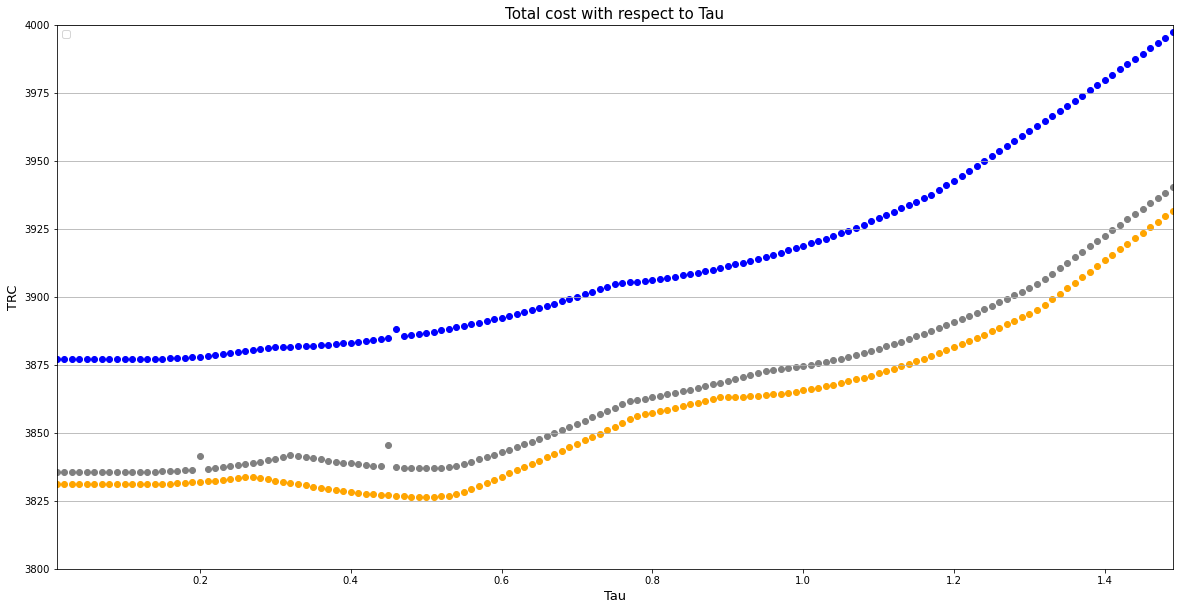

In [14]:
fig = plt.figure()
fig, ax = plt.subplots()
ax.set_xlabel('Tau',fontsize=13)
plt.xlim(0.01,1.49)
plt.ylim(3800,4000)
ax.set_ylabel('TRC',fontsize=13)
ax.set_title('Total cost with respect to Tau', fontsize=15)
ax.legend()
ax.grid(axis='y')
plt.gcf().set_size_inches(20, 10)
ax.scatter(tau, obj_list_my, color='orange')
ax.scatter(tau, obj_list_my_r1, color='blue')
ax.scatter(tau, obj_list_my_r01, color='grey')


In [31]:
(obj_list_my_r01.index(3835.6849773213353))

0

In [29]:
tau[49]

0.5

# Expensive Holding Cost

# r=1

In [4]:
r=1

In [7]:
N = 3
T = 10
set_N = set(range(N))
set_T = set(range(T))
h = [6,7,6]
mu = [5,5,5]
s = [50,50,50]
Pmax = [10,10,10]
delta = [5,5,5]
alpha = 2
M = 1000000
tau = []
for i in range(0,150):
    tau.append(i*0.01)
tau.remove(0.0)
g_list = []
for j in range(len(tau)):
    g = [[Pmax[i] - delta[i]*np.exp(-(t+1)/tau[j]) for t in set_T] for i in set_N]
    g_list.append(g)

In [8]:
obj_list_high_h_r1=[]

m_my = Model()
l = [[m_my.add_var(name='l({},{})'.format(i,t)) for t in set_T] for i in set_N]
p = [[m_my.add_var(name='p({},{})'.format(i,t)) for t in set_T] for i in set_N]
w = [[[m_my.add_var(name='w({},{},{})'.format(i,t_p,t)) for t in set_T ]  for t_p in set_T] for i in set_N]
z = [[[m_my.add_var(name='z({},{},{})'.format(i,t_p,t)) for t in set_T ]  for t_p in set_T] for i in set_N]
y = [[m_my.add_var(name='y({},{})'.format(i,t), var_type=BINARY) for t in set_T] for i in set_N]
y_a = [[m_my.add_var(name='y_a({},{})'.format(i,t), var_type=BINARY) for t in set_T] for i in set_N]
y_w = [[m_my.add_var(name='y_w({},{})'.format(i,t),var_type=BINARY) for t in set_T] for i in set_N]

m_my.objective = minimize(xsum(s[i]*y[i][t] + h[i]*l[i][t] + mu[i]*xsum(w[i][t_p][t] for t_p in range(t+1)) for i in set_N  for t in set_T)
+ r*xsum(z[i][t_p][t+1] for i in set_N for t in (set_T-{9}) for t_p in range(t+1)))

for j in range(len(g_list)):
    l = [[m_my.add_var(name='l({},{})'.format(i,t)) for t in set_T] for i in set_N]
    p = [[m_my.add_var(name='p({},{})'.format(i,t)) for t in set_T] for i in set_N]
    w = [[[m_my.add_var(name='w({},{},{})'.format(i,t_p,t)) for t in set_T ]  for t_p in set_T] for i in set_N]
    z = [[[m_my.add_var(name='z({},{},{})'.format(i,t_p,t)) for t in set_T ]  for t_p in set_T] for i in set_N]
    y = [[m_my.add_var(name='y({},{})'.format(i,t), var_type=BINARY) for t in set_T] for i in set_N]
    y_a = [[m_my.add_var(name='y_a({},{})'.format(i,t), var_type=BINARY) for t in set_T] for i in set_N]
    y_w = [[m_my.add_var(name='y_w({},{})'.format(i,t),var_type=BINARY) for t in set_T] for i in set_N]

    m_my.objective = minimize(xsum(s[i]*y[i][t] + h[i]*l[i][t] + mu[i]*xsum(w[i][t_p][t] for t_p in range(t+1)) for i in set_N  for t in set_T)
    + r*xsum(z[i][t_p][t+1] for i in set_N for t in (set_T-{9}) for t_p in range(t+1)))
    
    #2
    for t in set_T:
            m_my += l[0][t] == xsum(p[0][t_p] - d[t_p] for t_p in range(t+1))

    #3
    for (i,t) in product(set_N-{0}, set_T):
            m_my += l[i][t] == xsum(p[i][t_p] - p[i-1][t_p] for t_p in range(t+1))

    #4
    for (i,t) in product(set_N,set_T):
            m_my += p[i][t] == xsum(w[i][t_p][t]*g_list[j][i][t-t_p] for t_p in range(t+1) )

    #5
    for (i,t_p,t) in product(set_N,range(t+1),set_T-{9}):
        m_my += w[i][t_p][t] - w[i][t_p][t+1] <= y[i][t+1]*M

    #6
    for (i,t_p,t) in product(set_N,range(t+1),set_T-{9}):
        m_my += w[i][t_p][t+1] - w[i][t_p][t] <= y[i][t+1]*M

    #7
    for (i,t) in product(set_N,set_T):
        #if y_a+y_w == 2:
            #alpha = 2
        #else: 
            #alpha = 1
        m_my += y_a[i][t] + y_w[i][t] <= alpha*y[i][t]

    #8
    for (i,t_p,t) in product(set_N,range(t+1),set_T-{9}):
        m_my += z[i][t_p][t+1] == w[i][t_p][t] - w[i][t_p][t+1]

    #9
    for (i,t) in product(set_N,set_T):
        m_my += w[i][t][t] <= y_a[i][t]*M

    #10
    for (i,t_p,t) in product(set_N,range(t+1),set_T-{9}):
        m_my += z[i][t_p][t] <= y_w[i][t]*M

    #11
    for (i,t_p,t) in product(set_N,range(t+1),set_T):
         m_my += z[i][t_p][t] >= 0


    #12
    for (i,t) in product (set_N,set_T):
        m_my += l[i][t] >= 0

    #13
    for (i,t_p,t) in product(set_N,range(t+1),set_T):
         m_my += w[i][t_p][t] >= 0 
        
    m_my.optimize()
    obj_list_high_h_r1.append(m_my.objective_value)
    m_my = Model()
    

In [10]:
with open('tau-TRC_my_high_h_r1.txt','w',encoding='UTF-8') as f3:
    for i in obj_list_high_h_r1:
        f3.write(str(i)+'\n')
f3.close()

In [12]:
obj_list_high_h_r1

[4125.959237181179,
 4125.959237181179,
 4125.959237181181,
 4125.959237181694,
 4125.959237257954,
 4125.959239333359,
 4125.959260457701,
 4125.9593760015805,
 4125.959793963374,
 4125.960929013996,
 4125.963439040871,
 4125.968210772562,
 4125.97630696293,
 4125.988898551941,
 4126.0072022685035,
 4126.032435141878,
 4126.0657893345015,
 4126.108419507094,
 4126.161452811111,
 4126.225986297124,
 4126.303106243715,
 4126.39388848238,
 4126.499416494946,
 4126.620730204451,
 4126.758925882077,
 4126.9150485420905,
 4127.090136498464,
 4127.28520159629,
 4127.501220572916,
 4127.739132483964,
 4127.999822694068,
 4128.284121665872,
 4128.592798162326,
 4128.022031975129,
 4127.356855170722,
 4126.687687330614,
 4126.017248560508,
 4125.348128658074,
 4124.682781356534,
 4124.023521642847,
 4123.372527915211,
 4122.731846991258,
 4122.103357165264,
 4121.4888091884,
 4120.889873331464,
 4120.308051604083,
 4119.744740010896,
 4119.2012596218465,
 4118.6785517984845,
 4118.178055361846,

# r=0.5

In [14]:
r=0.5

In [80]:
N = 3
T = 10
set_N = set(range(N))
set_T = set(range(T))
h = [6,7,6]
mu = [5,5,5]
s = [50,50,50]
Pmax = [10,10,10]
delta = [5,5,5]
alpha = 2
M = 1000000
tau = []
for i in range(0,150):
    tau.append(i*0.01)
tau.remove(0.0)
g_list = []
for j in range(len(tau)):
    g = [[Pmax[i] - delta[i]*np.exp(-(t+1)/tau[j]) for t in set_T] for i in set_N]
    g_list.append(g)

In [16]:
obj_list_high_h_r05=[]

m_my = Model()
l = [[m_my.add_var(name='l({},{})'.format(i,t)) for t in set_T] for i in set_N]
p = [[m_my.add_var(name='p({},{})'.format(i,t)) for t in set_T] for i in set_N]
w = [[[m_my.add_var(name='w({},{},{})'.format(i,t_p,t)) for t in set_T ]  for t_p in set_T] for i in set_N]
z = [[[m_my.add_var(name='z({},{},{})'.format(i,t_p,t)) for t in set_T ]  for t_p in set_T] for i in set_N]
y = [[m_my.add_var(name='y({},{})'.format(i,t), var_type=BINARY) for t in set_T] for i in set_N]
y_a = [[m_my.add_var(name='y_a({},{})'.format(i,t), var_type=BINARY) for t in set_T] for i in set_N]
y_w = [[m_my.add_var(name='y_w({},{})'.format(i,t),var_type=BINARY) for t in set_T] for i in set_N]

m_my.objective = minimize(xsum(s[i]*y[i][t] + h[i]*l[i][t] + mu[i]*xsum(w[i][t_p][t] for t_p in range(t+1)) for i in set_N  for t in set_T)
+ r*xsum(z[i][t_p][t+1] for i in set_N for t in (set_T-{9}) for t_p in range(t+1)))

for j in range(len(g_list)):
    l = [[m_my.add_var(name='l({},{})'.format(i,t)) for t in set_T] for i in set_N]
    p = [[m_my.add_var(name='p({},{})'.format(i,t)) for t in set_T] for i in set_N]
    w = [[[m_my.add_var(name='w({},{},{})'.format(i,t_p,t)) for t in set_T ]  for t_p in set_T] for i in set_N]
    z = [[[m_my.add_var(name='z({},{},{})'.format(i,t_p,t)) for t in set_T ]  for t_p in set_T] for i in set_N]
    y = [[m_my.add_var(name='y({},{})'.format(i,t), var_type=BINARY) for t in set_T] for i in set_N]
    y_a = [[m_my.add_var(name='y_a({},{})'.format(i,t), var_type=BINARY) for t in set_T] for i in set_N]
    y_w = [[m_my.add_var(name='y_w({},{})'.format(i,t),var_type=BINARY) for t in set_T] for i in set_N]

    m_my.objective = minimize(xsum(s[i]*y[i][t] + h[i]*l[i][t] + mu[i]*xsum(w[i][t_p][t] for t_p in range(t+1)) for i in set_N  for t in set_T)
    + r*xsum(z[i][t_p][t+1] for i in set_N for t in (set_T-{9}) for t_p in range(t+1)))
    
    #2
    for t in set_T:
            m_my += l[0][t] == xsum(p[0][t_p] - d[t_p] for t_p in range(t+1))

    #3
    for (i,t) in product(set_N-{0}, set_T):
            m_my += l[i][t] == xsum(p[i][t_p] - p[i-1][t_p] for t_p in range(t+1))

    #4
    for (i,t) in product(set_N,set_T):
            m_my += p[i][t] == xsum(w[i][t_p][t]*g_list[j][i][t-t_p] for t_p in range(t+1) )

    #5
    for (i,t_p,t) in product(set_N,range(t+1),set_T-{9}):
        m_my += w[i][t_p][t] - w[i][t_p][t+1] <= y[i][t+1]*M

    #6
    for (i,t_p,t) in product(set_N,range(t+1),set_T-{9}):
        m_my += w[i][t_p][t+1] - w[i][t_p][t] <= y[i][t+1]*M

    #7
    for (i,t) in product(set_N,set_T):
        #if y_a+y_w == 2:
            #alpha = 2
        #else: 
            #alpha = 1
        m_my += y_a[i][t] + y_w[i][t] <= alpha*y[i][t]

    #8
    for (i,t_p,t) in product(set_N,range(t+1),set_T-{9}):
        m_my += z[i][t_p][t+1] == w[i][t_p][t] - w[i][t_p][t+1]

    #9
    for (i,t) in product(set_N,set_T):
        m_my += w[i][t][t] <= y_a[i][t]*M

    #10
    for (i,t_p,t) in product(set_N,range(t+1),set_T-{9}):
        m_my += z[i][t_p][t] <= y_w[i][t]*M

    #11
    for (i,t_p,t) in product(set_N,range(t+1),set_T):
         m_my += z[i][t_p][t] >= 0


    #12
    for (i,t) in product (set_N,set_T):
        m_my += l[i][t] >= 0

    #13
    for (i,t_p,t) in product(set_N,range(t+1),set_T):
         m_my += w[i][t_p][t] >= 0 
        
    m_my.optimize()
    obj_list_high_h_r05.append(m_my.objective_value)
    m_my = Model()
    

In [17]:
with open('tau-TRC_my_high_h_r05.txt','w',encoding='UTF-8') as f3:
    for i in obj_list_high_h_r05:
        f3.write(str(i)+'\n')
f3.close()

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

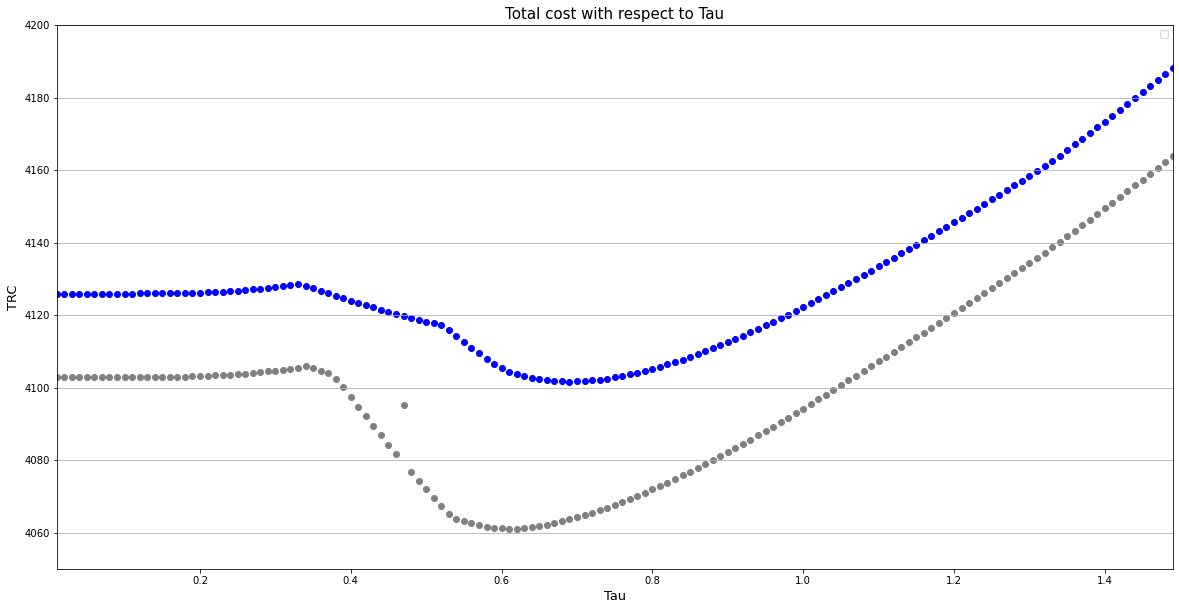

In [23]:
fig = plt.figure()
fig, ax = plt.subplots()
ax.set_xlabel('Tau',fontsize=13)
plt.xlim(0.01,1.49)
plt.ylim(4050,4200)
ax.set_ylabel('TRC',fontsize=13)
ax.set_title('Total cost with respect to Tau', fontsize=15)
ax.legend()
ax.grid(axis='y')
plt.gcf().set_size_inches(20, 10)
ax.scatter(tau, obj_list_high_h_r1, color='blue')
ax.scatter(tau, obj_list_high_h_r05, color='grey')

In [83]:
(obj_list_high_h_r1.index(4101.677873834498))

68

In [84]:
tau[68]

0.6900000000000001